# Project : INTRODUCTION TO MACHINE LEARNING

## Imports

In [5]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import math 
import random 
import matplotlib.pyplot as plt 
import time 

## Chargement des données

In [6]:
dataset = pd.read_csv("waveform.data.csv", sep=',', header=None)

dataset_shuffle = dataset.sample(frac=1.0, random_state=42)

X = dataset_shuffle.iloc[:, :-1]
y = dataset_shuffle.iloc[:, -1]


## k-NN

In [50]:

X_train = X.iloc[:4000]
y_train = y.iloc[:4000]

X_test = X.iloc[4000:]
y_test = y.iloc[4000:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [21]:

def distance_euclidienne(point1, point2):
    """
    Calcule la distance euclidienne entre deux points.
    """
    somme_carres = 0.0
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        somme_carres += difference ** 2
    return somme_carres ** 0.5

def knn_algorithm(x, k, metrique, X_train, y_train):
    """
    Prédit la classe d'un point x en utilisant l'algorithme k-NN.
    """
    list_distances = []
    
    # Convertir x en tableau numpy 2D pour cdist
    x_2d = np.array(x).reshape(1, -1)
    
    for i in range(len(X_train)):
        # dist = distance_euclidienne(x, X_train.iloc[i].values)
        
        # Méthode 2 : Avec cdist (plus rapide)
        point_2d = np.array(X_train.iloc[i]).reshape(1, -1)
        dist = cdist(x_2d, point_2d, metric=metrique)[0][0]
        
        list_distances.append((dist, i))

    list_distances.sort(key=lambda x: x[0])  # Trie par distance

    k_nearest_neighbors = list_distances[:k]
    votes = {}
    
    for dist, index in k_nearest_neighbors:
        label = y_train.iloc[index]
        votes[label] = votes.get(label,0) + 1

    return max(votes, key=votes.get)


""" Optimisation KNN en vectorisant nos données et en effectuant les 4 millions de calculs de distance en seulement une opération avec Numpy """

def knn_algorithm_vectorise(x, k, metrique, X_train, y_train):
    x_2d = np.array(x).reshape(1, -1)
    X_2d = np.array(X_train)
    
    distances = cdist(x_2d, X_2d, metric=metrique)[0]
    
    k_indices = np.argsort(distances)[:k]
    votes = y_train.iloc[k_indices].value_counts()
    return votes.idxmax()

def evaluer_modele(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(X_test)
    
    for i in range(total):
        point_test = X_test.iloc[i].values  # Convertir en numpy array
        vrai_label = y_test.iloc[i]
        
        # prediction = knn_algorithm(point_test, k, metrique, X_train, y_train)
        prediction = knn_algorithm_vectorise(point_test, k, metrique, X_train, y_train)
        if prediction == vrai_label.item():
            nombre_correct += 1
    
    return nombre_correct / total

def cross_validation_knn(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k

    Args:
        X: Features du dataset
        y: Labels du dataset complet
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance

    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        results: Dictionnaire avec les résultats pour chaque k
    """
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = len(X) // n_folds
    indices = np.arange(len(X))
    
    # mélanger les indices pour des folds aléatoires
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # créer des datasets pour ce fold
        X_train_fold = X.iloc[train_indices].reset_index(drop=True)
        y_train_fold = y.iloc[train_indices].reset_index(drop=True)
        X_val_fold = X.iloc[val_indices].reset_index(drop=True)
        y_val_fold = y.iloc[val_indices].reset_index(drop=True)
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies
    

# Utilisation
def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


### Execution

~ 2-4 minutes

In [22]:
def main_knn():
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + " avec k k={best_k}")
    print(f"Bayes optimal: 86%")


Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 48, précision de 0.8565


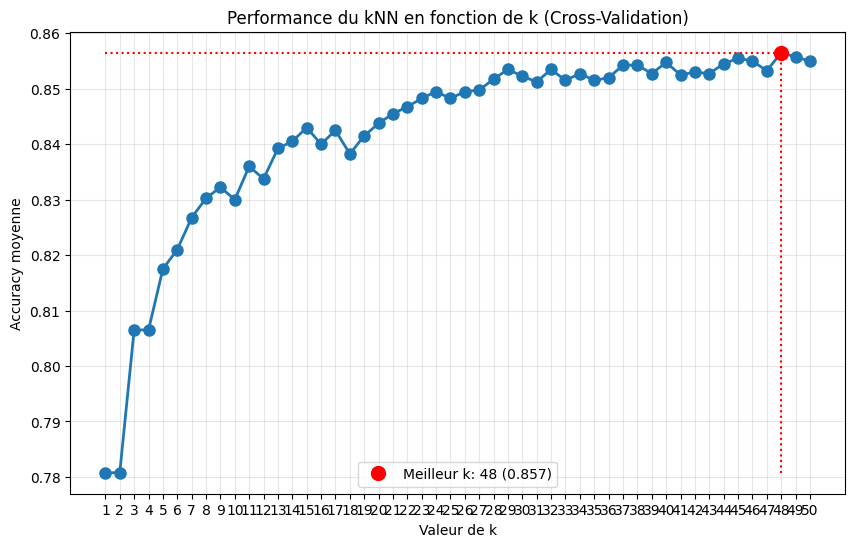

Accuracy finale sur le test set: 0.8590 (85.90%) avec k k={best_k}
Bayes optimal: 86%


In [53]:
main_knn()

### Test

In [8]:
# Test
accuracy = evaluer_modele(X_test, y_test, 5, 'euclidean', X_train, y_train)
print(f"Avec k=5, accuracy = {accuracy:.3f} ({accuracy*100:.1f}%)")

Avec k=5, accuracy = 0.823 (82.3%)


## Data reduction

In [3]:
def distance(v1,v2):
    """
    Renvoie la distance euclidiennes entre les vecteurs v1 et v2
    """
    somme = 0. 
    for x, y in zip(v1, v2):
        somme += (x - y) ** 2
    return math.sqrt(somme)

def un_NN(p, X, y): # TODO à optimiser en se servant des distances déjà calculées pour le k-NN 
    """
    1-NN 

    Args:
        p: Point à tester
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        label: label du point le plus proche 
    """

    # Initialisation 
    # dmin = distance(p, X[0])
    dmin = cdist(p.reshape(1, -1), X[0].reshape(1, -1), metric="euclidean")[0][0]
    label = y[0]

    for i in range(1, X.shape[0]):
        #d = distance(p, X[i])
        d = cdist(p.reshape(1, -1), X[i].reshape(1, -1), metric="euclidean")[0][0]
        if d < dmin: # si on trouve un point plus proche 
            dmin = d
            label = y[i]
    
    return label

def sep_data(X, y):
    """
    Mélange et sépare les données 

    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        l_id: Liste d'indices 
        milieu: indice du milieu
    """
    l_id = [i for i in range(X.shape[0])]
    random.shuffle(l_id)
    milieu = len(l_id) // 2
    return (l_id, milieu)

def reduction1(X, y):
    """
    1ère algorithme de réduction du dataset vu en cours 
    Suppression de la zone de biais 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Split randomly S into two subsets S1 and S2;
    (ordre, milieu) = sep_data(X, y)
    S1_X, S1_y = X[ordre[:milieu]], y[ordre[:milieu]]
    S2_X, S2_y = X[ordre[milieu:]], y[ordre[milieu:]]

    ch = True 
    while (ch): # Tant qu'il y a un changement S1 et S2 ne sont pas stabilisées 
        ch = False

        # Classify S1 with S2 using the 1-NN rule;
        # Remove from S1 the misclassified instances;
        nv_S1_X = []
        nv_S1_y = []
        for xi, yi in zip(S1_X, S1_y):
            l = un_NN(xi, S2_X, S2_y)
            if l == yi: 
                nv_S1_X.append(xi)
                nv_S1_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S1_X = np.array(nv_S1_X)
        S1_y = np.array(nv_S1_y)

        # Classify S2 with the new set S1 using the 1-NN rule;
        # Remove from S2 the misclassified instances;
        nv_S2_X = []
        nv_S2_y = []
        for xi, yi in zip(S2_X, S2_y):
            l = un_NN(xi, S1_X, S1_y)
            if l == yi: 
                nv_S2_X.append(xi)
                nv_S2_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S2_X = np.array(nv_S2_X)
        S2_y = np.array(nv_S2_y)
    
    # Union de S1 et S2 
    X_cleaned = np.concatenate((S1_X, S2_X), axis=0)
    y_cleaned = np.concatenate((S1_y, S2_y))
    
    return (X_cleaned, y_cleaned)

def reduction2(X, y):
    """
    2ème algorithme de réduction du dataset vu en cours 
    Suppression des données non pertinentes 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Initialisation
    STORAGE_X = []
    STORAGE_y = []
    DUSTBIN_X = []
    DUSTBIN_y = []

    # Draw randomly a training example from S and put it in STORAGE;
    idx0 = random.randint(0, X.shape[0] - 1)
    STORAGE_X.append(X[idx0])
    STORAGE_y.append(y[idx0])

    ch = True
    while (ch): # Tant que STORAGE n'est pas stabilisé 
        ch = False
        
        for xi, yi in zip(X, y):

            # Ne pas traiter un point déjà dans STORAGE 
            liste_STORAGE_X = [p.tolist() for p in STORAGE_X]
            if xi.tolist() in liste_STORAGE_X:
                continue

            l = un_NN(xi, np.array(STORAGE_X), np.array(STORAGE_y))

            if l == yi: # if xi is correctly classified with STORAGE using the 1-NN rule
                # bien classé -> poubelle (inutile)
                DUSTBIN_X.append(xi)
                DUSTBIN_y.append(yi)
            else:
                # mal classé -> stockage (utile)
                STORAGE_X.append(xi)
                STORAGE_y.append(yi)
                ch = True

    return (np.array(STORAGE_X), np.array(STORAGE_y))


### PCA

In [15]:
def pca(X, y, titre):
    """
    PCA
    
    Args:
        X: Features du dataset
        y: Labels du dataset 
        titre : titre du graphe
    """

    X_pca = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)

    labels = X_pca[:, -1].astype(int)
    X_features = X_pca[:, :-1]

    # Centrer les données (features)
    X_meaned = X_features - np.mean(X_features, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    # Valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # Tri décroissant
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # Projection sur les 2 premiers vecteurs propres
    eigenvector_subset = sorted_eigenvectors[:, 0:2]
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # Affichage avec couleur par label
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='viridis', edgecolor='k')

    # Ajouter une légende
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(titre)
    plt.grid(True)
    plt.show()

### Avant réduction 

In [11]:
# Les fonctions de réductions prennent des tableau numpy 
X_np = X.to_numpy()
y_np = y.to_numpy()

X_np_train = X_np[:4000, :]
y_np_train = y_np[:4000]

X_np_test = X_np[4000:, :]
y_np_test = y_np[4000:]

### 1ère réduction 

In [12]:
(X_train_cleaned, y_train_cleaned) = reduction1(X_np_train, y_np_train) 
print(X_np_train.shape, "-> X_cleaned :", X_train_cleaned.shape)

(4000, 21) -> X_cleaned : (3201, 21)


### 2ème réduction

In [13]:
(X_train_cleaned2, y_train_cleaned2) = reduction2(X_train_cleaned, y_train_cleaned)
print(X_train_cleaned.shape, "-> X_cleaned2 :", X_train_cleaned2.shape)

(3201, 21) -> X_cleaned2 : (707, 21)


## Affichage

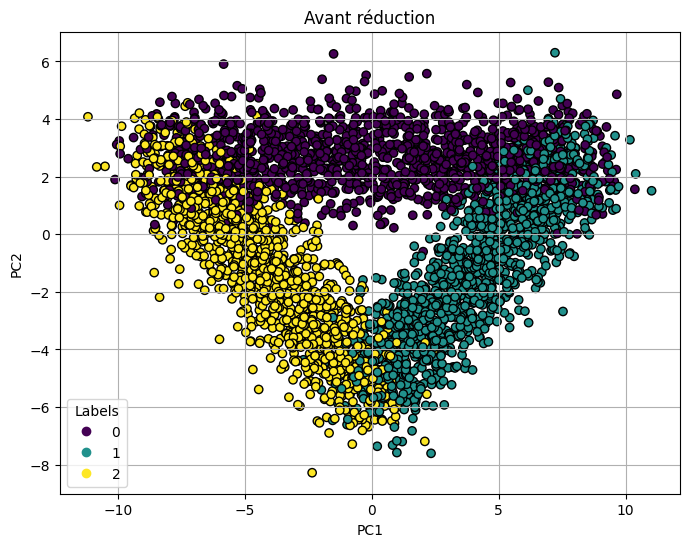

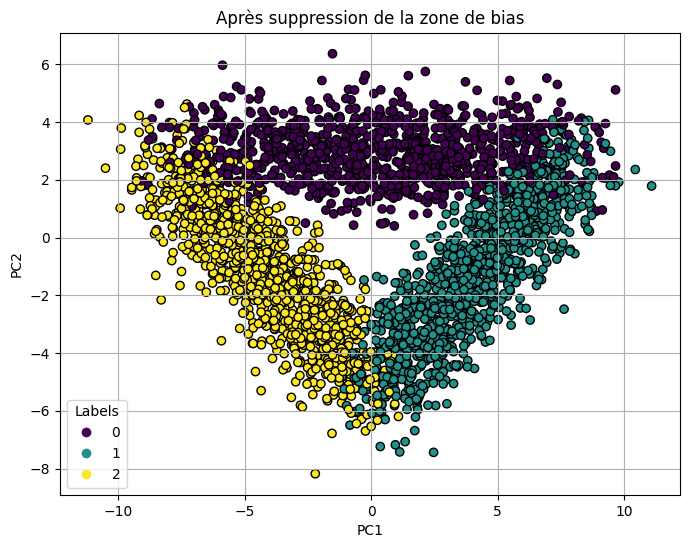

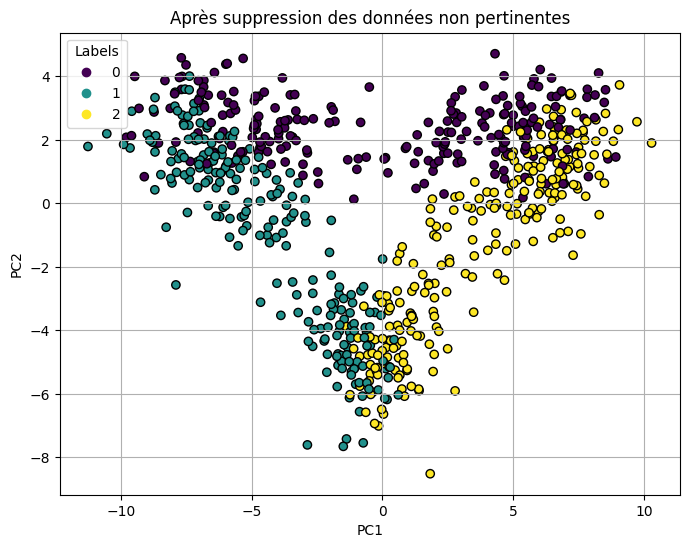

In [16]:
pca(X_np_train, y_np_train, "Avant réduction")
pca(X_train_cleaned, y_train_cleaned, "Après suppression de la zone de bias")
pca(X_train_cleaned2, y_train_cleaned2, "Après suppression des données non pertinentes")

## Lancement du k-NN après réduction des données 

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: None, précision de 0.0000


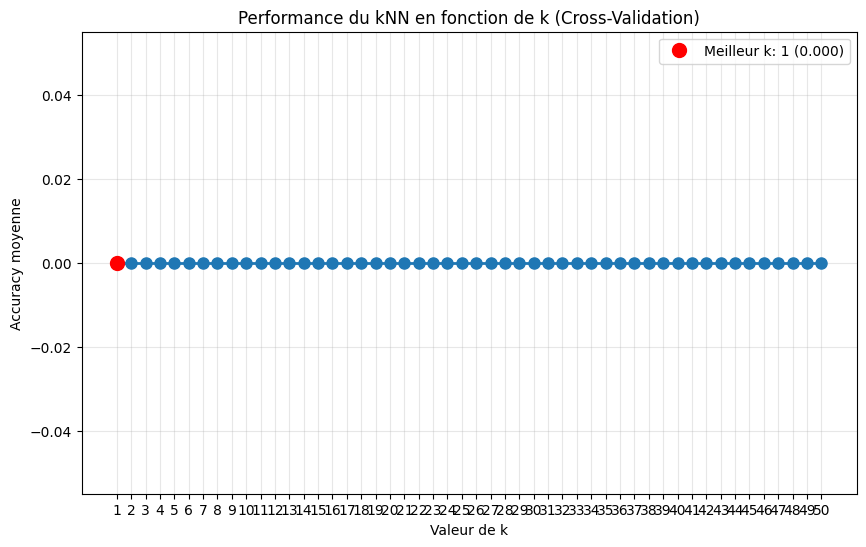

Accuracy finale sur le test set: 0.0000 (0.00%) avec k k={best_k}
Bayes optimal: 86%


In [23]:
X_train = X_train_cleaned2
y_train = y_train_cleaned2

X_test = X_np_test
y_test = y_np_test

X_train = pd.DataFrame(X_train).reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

main_knn()

## Avec distances précalculées

In [106]:

def knn_algorithm_vectorise(p_indice, k, indices_train, D, y_np):
    """
    Args:
        p_indice : indice du point (numpy)
        k : nb voisins
        indices_train : indices des données d'entraînement 
        D : matrices des distances 
    """

    distances = D[p_indice, indices_train]  # distances du point test aux points d'entraînement
    k_indices = np.argsort(distances)[:k]
    k_nearest = [indices_train[i] for i in k_indices]
    votes = y_np[k_nearest].astype(int)
    return np.bincount(votes).argmax()


def evaluer_modele(X_np, y_np, indices_test, k, indices_train, D):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(indices_test)
    
    for i in indices_test:
        vrai_label = y_np[i]
        
        prediction = knn_algorithm_vectorise(i, k, indices_train, D, y_np)
        if prediction == vrai_label:
            nombre_correct += 1
    
    return nombre_correct / total


def cross_validation_knn(X_np, y_np, k_values, n_folds=5):
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = X_np.shape[0] // n_folds
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")

    # Calcul de toutes les distances 
    D = cdist(X_np, X_np, metric='euclidean')
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        indices_test = [i for i in range(val_start, val_end)]
        indices_train = [i for i in range(X_np.shape[0]) if i not in indices_test]
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_np, y_np, indices_test, k, indices_train, D)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies


def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


def main_knn(X_np, y_np):
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 50 + 1))
    n = X_np.shape[0] * 4 // 5

    # Séparation des données
    indices_train = [i for i in range(n)]
    indices_test = [i for i in range(n, len(X))]

    X_train = X_np[:n]
    y_train = y_np[:n]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, len(X_np)))
    
    D = cdist(X_np, X_np, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_np, y_np, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")


def main_knn_exp(X_np_train, y_np_train, X_np_test, y_np_test, aff=False):
    k_values = list(range(1, 100 + 1)) # Pour trouver le meilleur k
    #k_values = [1] # Pour l'experience 1NN

    n = X_np_train.shape[0]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_np_train, y_np_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    if (aff):
        plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, n + X_np_test.shape[0]))

    Tout_X = np.concatenate((X_np_train, X_np_test), axis=0)
    Tout_y = np.concatenate((y_np_train, y_np_test), axis=0)
    
    D = cdist(Tout_X, Tout_X, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(Tout_X, Tout_y, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")

    return (best_k, best_accuracy, mean_accuracies, final_accuracy)


### Experience data reduction

In [103]:
main_knn_exp(X_np_train, y_np_train, X_np_test, y_np_test, aff=True)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...


KeyboardInterrupt: 

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.9522


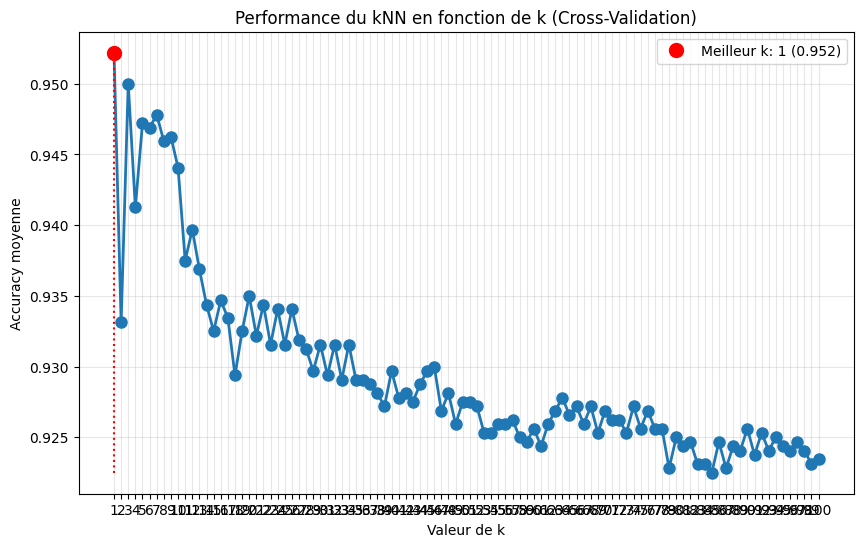

Accuracy finale sur le test set: 0.8160 (81.60%) avec k k=1
Bayes optimal: 86%


(1,
 np.float64(0.9521875),
 {1: np.float64(0.9521875),
  2: np.float64(0.9331250000000001),
  3: np.float64(0.95),
  4: np.float64(0.9412499999999999),
  5: np.float64(0.9471875000000001),
  6: np.float64(0.946875),
  7: np.float64(0.9478125000000001),
  8: np.float64(0.9459375),
  9: np.float64(0.94625),
  10: np.float64(0.9440625),
  11: np.float64(0.9375),
  12: np.float64(0.9396875),
  13: np.float64(0.936875),
  14: np.float64(0.934375),
  15: np.float64(0.9325000000000001),
  16: np.float64(0.9346875000000001),
  17: np.float64(0.9334374999999999),
  18: np.float64(0.9293750000000001),
  19: np.float64(0.9324999999999999),
  20: np.float64(0.9349999999999999),
  21: np.float64(0.9321874999999998),
  22: np.float64(0.934375),
  23: np.float64(0.9315624999999998),
  24: np.float64(0.9340624999999999),
  25: np.float64(0.9315625000000001),
  26: np.float64(0.9340624999999999),
  27: np.float64(0.931875),
  28: np.float64(0.93125),
  29: np.float64(0.9296875),
  30: np.float64(0.931

In [32]:
main_knn_exp(X_train_cleaned, y_train_cleaned, X_np_test, y_np_test, aff=True)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 60, précision de 0.8170


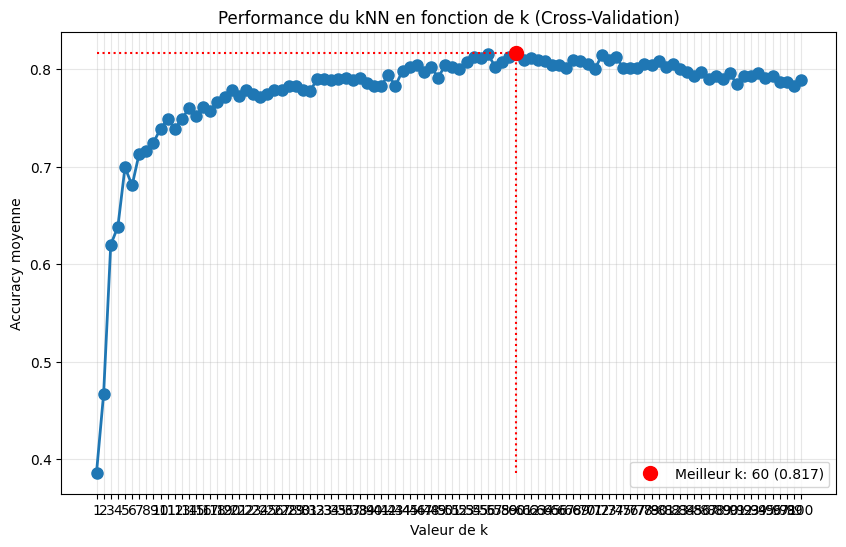

Accuracy finale sur le test set: 0.8440 (84.40%) avec k k=60
Bayes optimal: 86%


(60,
 np.float64(0.8170212765957446),
 {1: np.float64(0.38581560283687943),
  2: np.float64(0.4666666666666667),
  3: np.float64(0.6198581560283688),
  4: np.float64(0.6382978723404256),
  5: np.float64(0.699290780141844),
  6: np.float64(0.6808510638297871),
  7: np.float64(0.7134751773049646),
  8: np.float64(0.7163120567375887),
  9: np.float64(0.7248226950354609),
  10: np.float64(0.7390070921985817),
  11: np.float64(0.7489361702127659),
  12: np.float64(0.7390070921985815),
  13: np.float64(0.7489361702127659),
  14: np.float64(0.7602836879432624),
  15: np.float64(0.7517730496453899),
  16: np.float64(0.7617021276595745),
  17: np.float64(0.7574468085106383),
  18: np.float64(0.7659574468085106),
  19: np.float64(0.7716312056737589),
  20: np.float64(0.7787234042553192),
  21: np.float64(0.7730496453900709),
  22: np.float64(0.7787234042553192),
  23: np.float64(0.774468085106383),
  24: np.float64(0.7716312056737589),
  25: np.float64(0.774468085106383),
  26: np.float64(0.7787

In [34]:
main_knn_exp(X_train_cleaned2, y_train_cleaned2, X_np_test, y_np_test, aff=True)

In [ ]:

data_depart = np.concatenate((X_np_train, y_np_train.reshape(-1, 1)), axis=1)
data_reduction1 = np.concatenate((X_train_cleaned, y_train_cleaned.reshape(-1, 1)), axis=1)
data_reduction2 = np.concatenate((X_train_cleaned2, y_train_cleaned2.reshape(-1, 1)), axis=1)


In [40]:

exp_best_k = [[], [], []]
exp_best_accuracy = [[], [], []]
exp_mean_accuracies = [[], [], []]
exp_final_accuracy = [[], [], []]
exp_temps = [[], [], []]
exp_seed = [99]

In [ ]:
nb_exp = 50

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp_seed.append(exp_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]

    num = 0
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)
    
    num = 1
    (exp_X, exp_y) = reduction1(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)
    
    num = 2
    (exp_X, exp_y) = reduction2(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)

print("FIN")


N = 1 / 11
Début de la cross-validation (5 folds) pour les k: [1]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.7740
Accuracy finale sur le test set: 0.7850 (78.50%) avec k k=1
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.9464
Accuracy finale sur le test set: 0.8090 (80.90%) avec k k=1
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.3700
Accuracy finale sur le test set: 0.7580 (75.80%) avec k k=1
Bayes optimal: 86%
N = 2 / 11
Début de la cross-validation (5 folds) pour les k: [1]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.7768
Accuracy finale sur le test set: 0.7850 (78.50%) avec k k=1
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1]

In [67]:
print(len(exp_best_accuracy[0]))
print(len(exp_best_k[0]))
print(len(exp_final_accuracy[0]))
print(len(exp_mean_accuracies[0]))
print(len(exp_temps[0]))

print(exp_seed)
print(len(exp_seed))


50
50
50
50
50
[99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
51


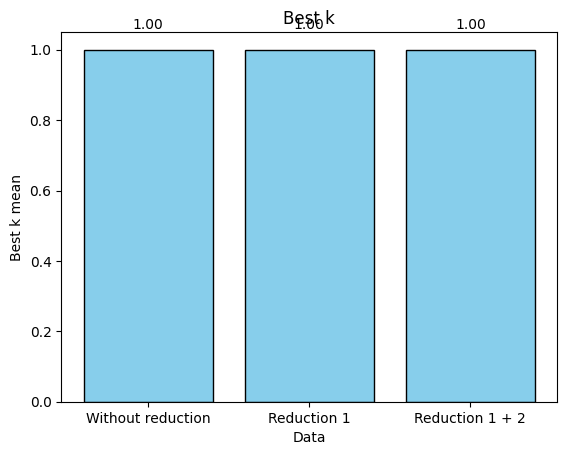

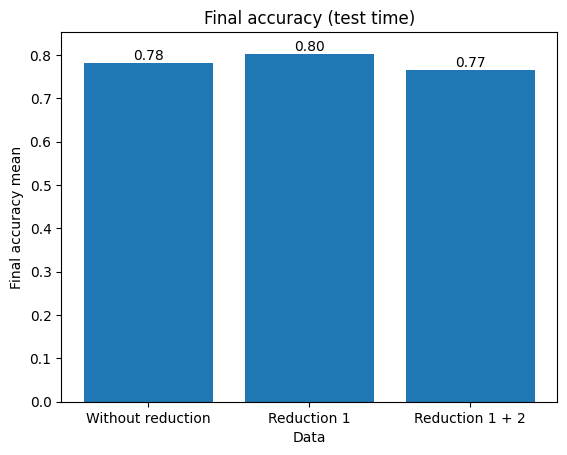

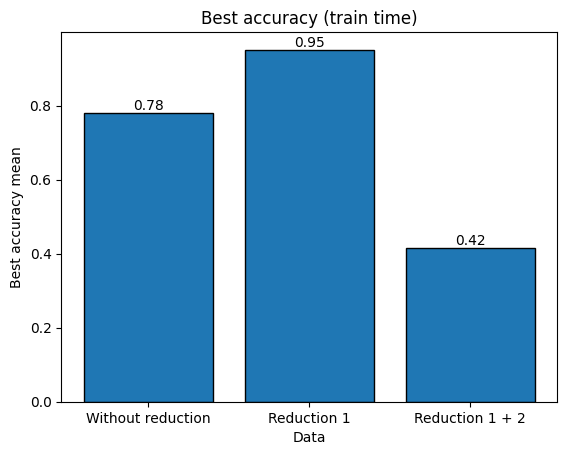

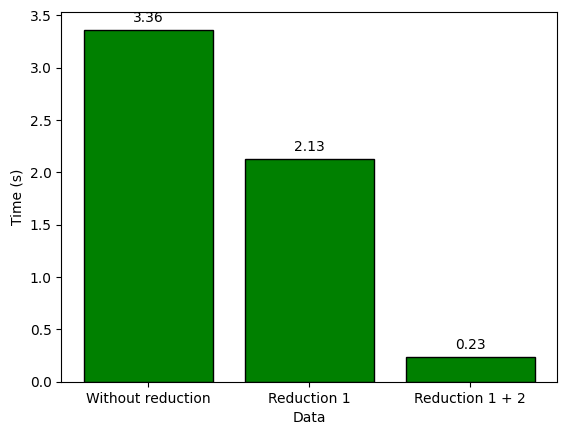

In [68]:
labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2']

valeurs = [np.mean(np.array(exp_best_k[0])), np.mean(np.array(exp_best_k[1])), np.mean(np.array(exp_best_k[2]))]
plt.bar(labels, valeurs, color='skyblue', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best k")
plt.xlabel("Data")
plt.ylabel("Best k mean")

plt.show()

valeurs = [np.mean(np.array(exp_final_accuracy[0])), np.mean(np.array(exp_final_accuracy[1])), np.mean(np.array(exp_final_accuracy[2]))]
plt.bar(labels, valeurs)

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

y_max = max(valeurs)
plt.ylim(0, y_max + 0.05)

plt.title("Final accuracy (test time)")
plt.xlabel("Data")
plt.ylabel("Final accuracy mean")

plt.show()

valeurs = [np.mean(np.array(exp_best_accuracy[0])), np.mean(np.array(exp_best_accuracy[1])), np.mean(np.array(exp_best_accuracy[2]))]
plt.bar(labels, valeurs, edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best accuracy (train time)")
plt.xlabel("Data")
plt.ylabel("Best accuracy mean")

plt.show()


labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2'] 

valeurs = [np.mean(np.array(exp_temps[0])), np.mean(np.array(exp_temps[1])), np.mean(np.array(exp_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

### Calcul du temps d'exécution

In [18]:
exp_temps = [[], [], []]

nb_exp = 10

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    num = 0
    exp_data = data_depart.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)
    
    num = 1
    exp_data = data_reduction1.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)
    
    num = 2
    exp_data = data_reduction2.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)

print("FIN")


N = 1 / 10
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 72, précision de 0.8575
Accuracy finale sur le test set: 0.8740 (87.40%) avec k k=72
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 

In [1]:
labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2'] 

valeurs = [np.mean(np.array(exp_temps[0])), np.mean(np.array(exp_temps[1])), np.mean(np.array(exp_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

NameError: name 'np' is not defined

### Test kNN

In [73]:
exp2_best_k = [[], [], []]
exp2_best_accuracy = [[], [], []]
exp2_mean_accuracies = [[], [], []]
exp2_final_accuracy = [[], [], []]
exp2_temps = [[], [], []]
exp2_seed = [99]

In [96]:
nb_exp = 4

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp2_seed.append(exp2_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp2_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]

    num = 0
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp2_best_k[num].append(best_k)
    exp2_best_accuracy[num].append(best_accuracy)
    exp2_mean_accuracies[num].append(mean_accuracies)
    exp2_final_accuracy[num].append(final_accuracy)
    exp2_temps[num].append(fin - debut)
    

print("FIN")


N = 1 / 4
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 54, précision de 0.8585
Accuracy finale sur le test set: 0.8540 (85.40%) avec k k=54
Bayes optimal: 86%
N = 2 / 4
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,

In [99]:
print((exp2_best_accuracy[0]))
print((exp2_best_k[0]))
print((exp2_final_accuracy[0]))
print(len(exp2_mean_accuracies[0]))
print((exp2_temps[0]))

#print(exp2_temps[0])
#print(exp2_best_k[0])
print(exp2_seed)
print(len(exp2_seed))

[np.float64(0.8552500000000001), np.float64(0.8557499999999999), np.float64(0.8560000000000001), np.float64(0.86175), np.float64(0.852), np.float64(0.85375), np.float64(0.8564999999999999), np.float64(0.8627499999999999), np.float64(0.85625), np.float64(0.86075), np.float64(0.8647500000000001), np.float64(0.8605), np.float64(0.85975), np.float64(0.8522500000000001), np.float64(0.85375), np.float64(0.8554999999999999), np.float64(0.8565000000000002), np.float64(0.86175), np.float64(0.859), np.float64(0.85925), np.float64(0.86075), np.float64(0.8627499999999999), np.float64(0.8535), np.float64(0.8612500000000001), np.float64(0.8522500000000001), np.float64(0.857), np.float64(0.8567499999999999), np.float64(0.8539999999999999), np.float64(0.8592500000000001), np.float64(0.858), np.float64(0.8585), np.float64(0.8610000000000001), np.float64(0.8559999999999999), np.float64(0.8574999999999999), np.float64(0.8554999999999999), np.float64(0.85825), np.float64(0.85125), np.float64(0.86225000000

In [100]:
print("best k =", np.mean(np.array(exp2_best_k[0])))
print("final accuracy =", np.mean(np.array(exp2_final_accuracy[0])))
print("best accuracy =", np.mean(np.array(exp2_best_accuracy[0])))
print("temps =", np.mean(np.array(exp2_temps[0])))

best k = 70.5
final accuracy = 0.8594599999999999
best accuracy = 0.85828
temps = 152.74824287414552


## Inégalitée triangulaire

In [107]:
def knn_algorithm_triangle_inequality(point_test, k, metrique, X_train, y_train, D_precalc=None):
    """
    KNN avec optimisation par inégalité triangulaire
    
    Pour un point Xi:
    Si d(X,Xi) > d_min alors les points d'entraînement qui sont:
    - dans la sphère centrée en Xi de rayon d(X,Xi) - d_min
    - hors de la sphère centrée en Xi de rayon d(X,Xi) + d_min
    ne peuvent pas être NN(X)
    
    Args:
        point_test: point à classifier
        k: nombre de voisins
        metrique: métrique de distance
        X_train: données d'entraînement
        y_train: labels d'entraînement
        D_precalc: matrice de distances précalculée (optionnel)
    """
    # Convertir en numpy array
    x_2d = np.array(point_test).reshape(1, -1)
    X_train_np = np.array(X_train)
    
    # Calcul des distances du point test à tous les points d'entraînement
    distances = cdist(x_2d, X_train_np, metric=metrique)[0]
    
    # Tri des indices par distance croissante
    sorted_indices = np.argsort(distances)
    
    # Initialisation: X' = premier voisin le plus proche (X1 dans les diapos)
    first_idx = sorted_indices[0]
    d_min = distances[first_idx]  # distance au voisin le plus proche actuel
    
    # Liste pour stocker les k plus proches voisins
    k_nearest_indices = [first_idx]
    k_nearest_distances = [d_min]
    
    # Compter les points éliminés pour statistiques
    eliminated_count = 0
    
    # Parcourir les autres points dans l'ordre croissant de distance
    for idx in sorted_indices[1:]:
        # Si on a déjà k voisins et que la distance actuelle 
        # est supérieure à la k-ième distance, on peut s'arrêter
        if len(k_nearest_indices) >= k:
            if distances[idx] > max(k_nearest_distances):
                break
        
        d_X_Xi = distances[idx]  # d(X, Xi) où Xi est le point candidat actuel
        
        # Vérifier si on peut éliminer ce point avec l'inégalité triangulaire
        can_eliminate = False
        
        # Pour chaque voisin déjà trouvé (seulement le meilleur pour optimiser)
        # On utilise X' (le voisin le plus proche actuel)
        if d_X_Xi > d_min:
            # Calcul de d(X', Xi) où X' est le voisin le plus proche actuel
            X_prime_idx = k_nearest_indices[0]  # X' = premier voisin
            d_Xprime_Xi = cdist(
                X_train_np[X_prime_idx].reshape(1, -1),
                X_train_np[idx].reshape(1, -1),
                metric=metrique
            )[0][0]
            
            # Si Xi est dans la sphère centrée en X' de rayon d(X,Xi) - d_min
            # Alors d(X', Xi) ≤ d(X, Xi) - d_min
            # d(X', Xi) + d_min ≤ d(X, Xi)
            # Ce qui implique que Xi ne peut pas être plus proche que X'
            if d_Xprime_Xi + d_min <= d_X_Xi:
                can_eliminate = True
                eliminated_count += 1
        
        if not can_eliminate:
            k_nearest_indices.append(idx)
            k_nearest_distances.append(d_X_Xi)
            
            # Mettre à jour d_min si on a trouvé un voisin plus proche
            if d_X_Xi < d_min:
                d_min = d_X_Xi
                # Réorganiser pour que le plus proche soit toujours en premier
                k_nearest_indices[0], k_nearest_indices[-1] = k_nearest_indices[-1], k_nearest_indices[0]
                k_nearest_distances[0], k_nearest_distances[-1] = k_nearest_distances[-1], k_nearest_distances[0]
    
    # Garder seulement les k plus proches
    if len(k_nearest_indices) > k:
        sorted_k = np.argsort(k_nearest_distances)[:k]
        k_nearest_indices = [k_nearest_indices[i] for i in sorted_k]
    
    # Vote majoritaire
    votes = {}
    for idx in k_nearest_indices:
        label = y_train.iloc[idx] if hasattr(y_train, 'iloc') else y_train[idx]
        votes[label] = votes.get(label, 0) + 1
    
    return max(votes, key=votes.get)


def evaluer_modele_triangle_inequality(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN avec optimisation par inégalité triangulaire
    """
    nombre_correct = 0
    total = len(X_test)
    
    for i in range(total):
        point_test = X_test.iloc[i].values if hasattr(X_test, 'iloc') else X_test[i]
        vrai_label = y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]
        
        prediction = knn_algorithm_triangle_inequality(point_test, k, metrique, X_train, y_train)
        
        # Gestion des types pandas
        if hasattr(vrai_label, 'item'):
            vrai_label = vrai_label.item()
        
        if prediction == vrai_label:
            nombre_correct += 1
    
    return nombre_correct / total


def cross_validation_knn_triangle_inequality(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k avec inégalité triangulaire
    
    Args:
        X: Features du dataset
        y: Labels du dataset complet
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance
    
    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        mean_accuracies: Dictionnaire avec les résultats pour chaque k
    """
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = len(X) // n_folds
    indices = np.arange(len(X))
    
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) avec inégalité triangulaire pour les k: {k_values}")
    
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # créer des datasets pour ce fold
        X_train_fold = X.iloc[train_indices].reset_index(drop=True)
        y_train_fold = y.iloc[train_indices].reset_index(drop=True)
        X_val_fold = X.iloc[val_indices].reset_index(drop=True)
        y_val_fold = y.iloc[val_indices].reset_index(drop=True)
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele_triangle_inequality(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies


def plot_results_triangle(mean_accuracies):
    """Trace les résultats de la cross-validation avec inégalité triangulaire"""
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN avec inégalité triangulaire en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


def main_knn_triangle_inequality(X_train, y_train, X_test, y_test):
    # utilise seulement les points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn_triangle_inequality(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\nMeilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results_triangle(mean_accuracies)
    
    # test set avec le meilleur k
    final_accuracy = evaluer_modele_triangle_inequality(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%) avec k={best_k}")
    print(f"Bayes optimal: 86%")
    
    return best_k, best_accuracy, mean_accuracies, final_accuracy

Début de la cross-validation (5 folds) avec inégalité triangulaire pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

Meilleur k: 41, précision de 0.7973


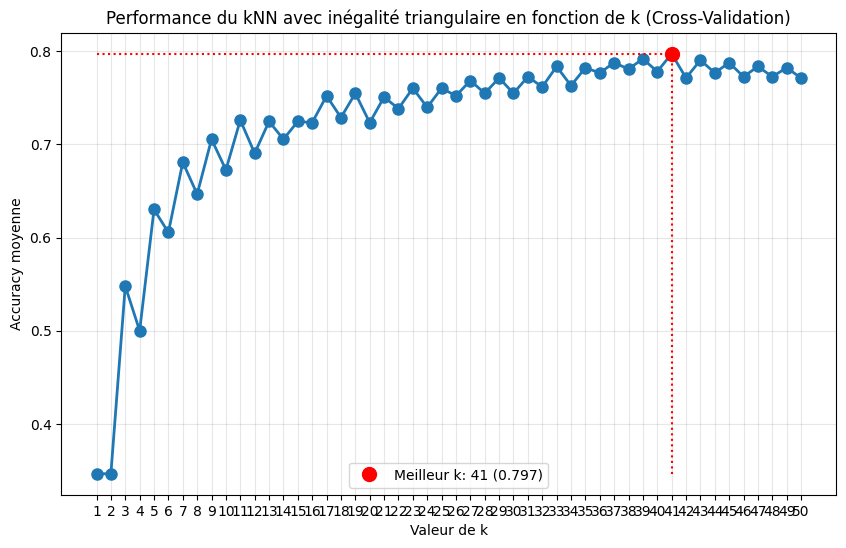

Accuracy finale sur le test set: 0.8087 (80.87%) avec k=41
Bayes optimal: 86%


In [ ]:
best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_triangle_inequality(X_train, y_train, X_test, y_test)

## kd-tree

In [108]:
from collections import Counter, defaultdict
from heapq import heappush, heappop
from random import shuffle

# Noeud du kd-tree 
class KDNode:
    def __init__(self, point, label, left=None, right=None, axis=0):
        self.point = point
        self.label = label
        self.left = left
        self.right = right
        self.axis = axis


def construire_kdtree(points, prof=0):
    """
    Construction optimisée du kd-tree 
    """
    if not points:
        return None
    k = len(points[0][0])
    axis = prof % k
    points.sort(key=lambda x: x[0][axis])
    milieu = len(points) // 2
    return KDNode(
        point=points[milieu][0],
        label=points[milieu][1],
        left=construire_kdtree(points[:milieu], prof + 1),
        right=construire_kdtree(points[milieu + 1:], prof + 1),
        axis=axis
    )
 
def distance_carre(p1, p2):
    """
    Distance euclidienne au carré entre p1 et p2
    """
    return sum((a - b) ** 2 for a, b in zip(p1, p2))
 
def knn_recherche(racine, target, k):
    """
    Recherche k-NN optimisée dans le kd-tree
    """
    heap = []

    def rec_recherche(node):
        if node is None:
            return

        dist2 = distance_carre(target, node.point)
        heappush(heap, (-dist2, node.label))
        if len(heap) > k:
            heappop(heap)

        axis = node.axis
        diff = target[axis] - node.point[axis]

        close_branch = node.left if diff < 0 else node.right
        far_branch = node.right if diff < 0 else node.left

        rec_recherche(close_branch)

        if len(heap) < k or diff ** 2 < -heap[0][0]:
            rec_recherche(far_branch)

    rec_recherche(racine)
    return [label for _, label in sorted(heap, reverse=True)]
 
def prediction_kdtree(tree, point, k=3):
    """
    Prédiction par vote majoritaire
    """
    neighbors = knn_recherche(tree, point, k)
    vote = Counter(neighbors)
    return vote.most_common(1)[0][0]


def plot_k_accuracy(k_to_avg_accuracy):
    """
    Affichage du graphe précision vs k
    """
    ks = sorted(k_to_avg_accuracy.keys())
    accs = [k_to_avg_accuracy[k] for k in ks]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, accs, marker='o', linestyle='-', color='teal')
    plt.title("Précision moyenne vs k (k-NN avec kd-tree)")
    plt.xlabel("k (nombre de voisins)")
    plt.ylabel("Précision moyenne")
    plt.grid(True)
    plt.xticks(ks)
    plt.ylim(0, 1)
    plt.show()


In [109]:
def kdtree_cross_validation_knn(X, y, k_values, n_splits=5):
    X = list(X)
    y = list(y)

    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)

    folds = [[] for _ in range(n_splits)]
    for label, indices in class_indices.items():
        shuffle(indices)
        for i, idx in enumerate(indices):
            folds[i % n_splits].append(idx)

    k_to_accuracies = defaultdict(list)

    print(f"Début de la cross-validation sur {n_splits} folds...\n")

    for k in k_values:
        print(f"Test de k = {k}")
        for i in range(n_splits):
            print(f"-> Fold {i+1}/{n_splits}...", end=' ', flush=True)

            test_idx = folds[i]
            train_idx = [idx for j in range(n_splits) if j != i for idx in folds[j]]

            X_train = [X[j] for j in train_idx]
            y_train = [y[j] for j in train_idx]
            X_test = [X[j] for j in test_idx]
            y_test = [y[j] for j in test_idx]

            train_data = list(zip(X_train, y_train))
            kdtree = construire_kdtree(train_data)

            y_pred = [prediction_kdtree(kdtree, x_test, k=k) for x_test in X_test]
            correct = sum(1 for pred, true in zip(y_pred, y_test) if pred == true)
            accuracy = correct / len(y_test)

            print(f"Précision : {accuracy:.3f}")
            k_to_accuracies[k].append(accuracy)

        avg_acc = np.mean(k_to_accuracies[k])
        print(f"Moyenne pour k = {k} : {avg_acc:.3f}\n")

    k_to_avg_accuracy = {k: np.max(accs) for k, accs in k_to_accuracies.items()}
    best_k = max(k_to_avg_accuracy, key=k_to_avg_accuracy.get)
    best_accuracy = k_to_avg_accuracy[best_k]

    print("Résultats fin :")
    for k, acc in sorted(k_to_avg_accuracy.items()):
        print(f"  k = {k} → précision moyenne : {acc:.3f}")

    print(f"\nMeilleur k trouvé : {best_k}\n")

    return best_k, best_accuracy, k_to_avg_accuracy


In [110]:
def main_knn_kdtree(X_train, y_train, X_test, y_test, aff=False):
    # utilise seulement les points d'entraînement pour la CV
    k_values = list(range(1, 50 + 1))
    
    best_k, best_accuracy, mean_accuracies = kdtree_cross_validation_knn(
        X_train, y_train, k_values, n_splits=5
    )
    
    print(f"\nMeilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    if aff:
        plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    train_data = list(zip(X_train, y_train))
    kdtree = construire_kdtree(train_data)
    y_pred = [prediction_kdtree(kdtree, xi, k=best_k) for xi in X_test]
    correct = sum(1 for pred, true in zip(y_pred, y_test) if pred == true)
    final_accuracy = correct / len(y_test)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%) avec k={best_k}")
    print(f"Bayes optimal: 86%")
    
    return best_k, best_accuracy, mean_accuracies, final_accuracy

In [101]:

# # Exemple d'utilisation
# k_values = [i for i in range(1, 50 + 1)]
# best_k, accuracies = kdtree_cross_validation_knn(X_cleaned2, y_cleaned2, k_values, n_splits=5)

# print("Précision moyenne pour chaque k :")
# for k, acc in accuracies.items():
#     print(f"k = {k} → {acc*100:.2f}%")

# print(f"\nMeilleur k : {best_k}")
# plot_k_accuracy(accuracies)


## Compare knn (first version), inégalité traingulaire, kdtree 

In [104]:
exp3_best_k = [[], [], []]
exp3_best_accuracy = [[], [], []]
exp3_mean_accuracies = [[], [], []]
exp3_final_accuracy = [[], [], []]
exp3_temps = [[], [], []]
exp3_seed = [99]

In [ ]:
# main_knn_triangle_inequality(X_train, y_train, X_test, y_test)
# main_knn_kdtree(X_train, y_train, X_test, y_test)

In [111]:
nb_exp = 1

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp_seed.append(exp_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]
    
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]

    num = 0
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)
    
    num = 1
    (exp_X, exp_y) = reduction1(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_triangle_inequality(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)
    
    num = 2
    (exp_X, exp_y) = reduction2(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_kdtree(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)

print("FIN")


N = 1 / 1
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 62, précision de 0.8648
Accuracy finale sur le test set: 0.8610 (86.10%) avec k k=62
Bayes optimal: 86%
Début de la cross-validation (5 folds) avec inégalité triangulaire pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [105]:
print(len(exp3_best_accuracy[0]))
print(len(exp3_best_k[0]))
print(len(exp3_final_accuracy[0]))
print(len(exp3_mean_accuracies[0]))
print(len(exp3_temps[0]))

print(exp3_seed)
print(len(exp3_seed))

0
0
0
0
0
[99]
1


In [ ]:
labels = ['kNN (1st version)', 'Triangle inequality', 'kd-tree']

valeurs = [np.mean(np.array(exp3_best_k[0])), np.mean(np.array(exp3_best_k[1])), np.mean(np.array(exp3_best_k[2]))]
plt.bar(labels, valeurs, color='skyblue', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best k")
plt.xlabel("Data")
plt.ylabel("Best k mean")

plt.show()

valeurs = [np.mean(np.array(exp3_final_accuracy[0])), np.mean(np.array(exp3_final_accuracy[1])), np.mean(np.array(exp3_final_accuracy[2]))]
plt.bar(labels, valeurs)

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

y_max = max(valeurs)
plt.ylim(0, y_max + 0.05)

plt.title("Final accuracy (test time)")
plt.xlabel("Data")
plt.ylabel("Final accuracy mean")

plt.show()

valeurs = [np.mean(np.array(exp3_best_accuracy[0])), np.mean(np.array(exp3_best_accuracy[1])), np.mean(np.array(exp3_best_accuracy[2]))]
plt.bar(labels, valeurs, edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best accuracy (train time)")
plt.xlabel("Data")
plt.ylabel("Best accuracy mean")

plt.show()


valeurs = [np.mean(np.array(exp3_temps[0])), np.mean(np.array(exp3_temps[1])), np.mean(np.array(exp3_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

## Compare

In [1]:
import sklearn
print("scikit-learn version :", sklearn.__version__)

scikit-learn version : 1.7.2
